In [1]:
import datetime as dt
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/step3_features_summary.csv', parse_dates=['Time'], index_col='Time')
df.tail()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
2020-03-31,0.319261,0.246119,0.6,0.011520,2.2606,-1.8144
2020-06-30,-9.032775,0.164079,7.5,-0.079694,0.3934,-6.1079
2020-09-30,-2.848345,0.082040,4.3,-0.039605,1.3235,-0.9701
2020-12-31,-2.386694,0.000000,3.1,-0.020867,1.3449,-0.0180
2021-03-31,0.406168,0.000000,1.6,-0.136863,2.0686,5.3175


In [3]:
import joblib
filepath = 'models/var_model.pkl'
results = joblib.load(filepath)

## Forecasting

In [4]:
lag_order = results.k_ar
results.forecast(df.values[-lag_order:], 8)

array([[-2.64497538e+01,  4.59002494e+00,  3.10261521e+00,
        -9.46016868e-02, -5.62053744e+00,  1.55694106e+01],
       [ 2.78603280e+01,  3.13337729e+00, -2.55557850e+01,
         3.27583111e-01,  1.14314224e+01,  3.66836209e+01],
       [ 5.00614694e+01,  4.28276480e-01, -3.40911857e+01,
         2.42779450e-01,  1.94988358e+01,  4.75907804e+01],
       [ 6.42916824e+01, -3.09512853e+00, -3.44816148e+01,
         2.32445053e-01, -9.66411124e+00, -3.95909804e+01],
       [-3.82324036e+01,  2.14674281e-01,  1.06258843e+01,
        -1.95417627e-02, -1.83515777e+01, -6.03065601e+01],
       [ 3.94736265e+01, -1.54759630e+01,  1.18746495e+01,
         4.04848174e-01,  3.54668288e+01, -6.12741444e+01],
       [-5.90755048e+01, -2.07204633e+01,  9.50478078e+01,
        -7.10091587e-01,  1.49966185e+00, -1.52214543e+02],
       [-8.53053358e+01, -2.06314177e+01,  1.25088083e+02,
        -1.26357538e+00, -5.51682481e+01, -1.77656639e+02]])

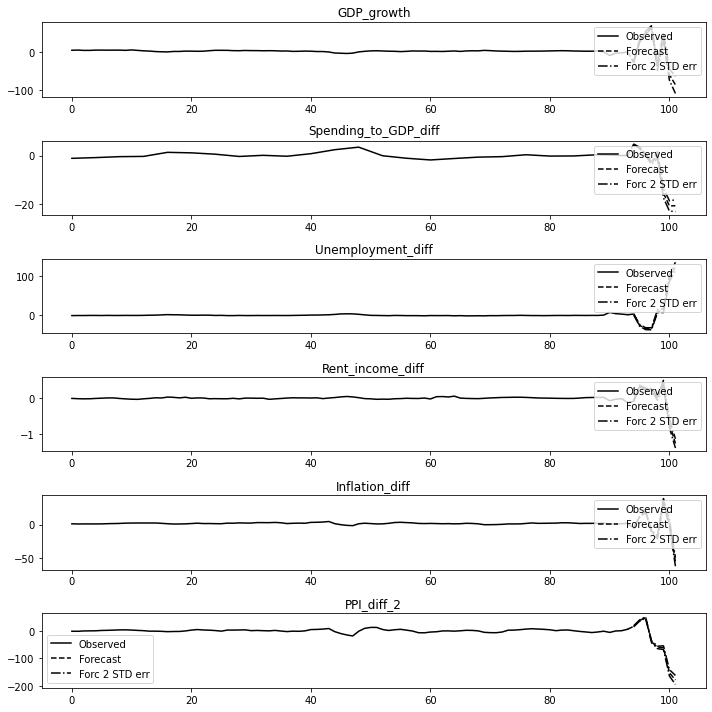

In [5]:
results.plot_forecast(8)
plt.legend(loc='left')
plt.tight_layout()

## Evaluation
Evaluate forecasting model using Forecast Error Variance Decomposition (FEVD) method

In [6]:
fevd = results.fevd(12)
fevd.summary()

FEVD for GDP_growth
      GDP_growth  Spending_to_GDP_diff  Unemployment_diff  Rent_income_diff  Inflation_diff  PPI_diff_2
0       1.000000              0.000000           0.000000          0.000000        0.000000    0.000000
1       0.635021              0.094911           0.220070          0.000776        0.048477    0.000745
2       0.525190              0.079211           0.225573          0.001209        0.163627    0.005189
3       0.499882              0.090208           0.207746          0.019965        0.174426    0.007773
4       0.833707              0.034269           0.049150          0.003260        0.078388    0.001227
5       0.715075              0.058671           0.082881          0.002761        0.139556    0.001056
6       0.691852              0.115702           0.055333          0.001637        0.133511    0.001965
7       0.678592              0.116288           0.131953          0.002461        0.065348    0.005358
8       0.768300              0.083346      

## Inverting
Invert data back to its original form, before differencing and log transformation

In [7]:
nobs = 8
predictions = results.forecast(results.y, steps=nobs)

In [8]:
df_forecast = pd.DataFrame(predictions, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()

,GDP_growth_1d,Spending_to_GDP_diff_1d,Unemployment_diff_1d,Rent_income_diff_1d,Inflation_diff_1d,PPI_diff_2_1d
Time,,,,,,
2020-03-31,64.291682,-3.095129,-34.481615,0.232445,-9.664111,-39.590980
2020-06-30,-38.232404,0.214674,10.625884,-0.019542,-18.351578,-60.306560
2020-09-30,39.473627,-15.475963,11.874650,0.404848,35.466829,-61.274144
2020-12-31,-59.075505,-20.720463,95.047808,-0.710092,1.499662,-152.214543
2021-03-31,-85.305336,-20.631418,125.088083,-1.263575,-55.168248,-177.656639


In [9]:
def invert_transformation(train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    cols = train.columns
    for col in cols:
        if second_diff:
            df_fc[str(col)+'_1d'] = (train[col].iloc[-4] - train[col].iloc[-8]) + df_fc[str(col)+'_1d'].cumsum()
        df_fc[str(col)+'_forecast'] = train[col].iloc[-4] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [10]:
train, test = df[0:-nobs], df[-nobs:]

In [11]:
df_results_1 = invert_transformation(train, df_forecast, second_diff=False)
df_results_1 = df_results_1.loc[:, ['Spending_to_GDP_diff_forecast', 'Unemployment_diff_forecast', 'Rent_income_diff_forecast', 'Inflation_diff_forecast']]
df_results_1

,Spending_to_GDP_diff_forecast,Unemployment_diff_forecast,Rent_income_diff_forecast,Inflation_diff_forecast
Time,,,,
2019-06-30,4.392331,2.802615,-0.110324,-2.820337
2019-09-30,7.525708,-22.753170,0.217259,8.611085
2019-12-31,7.953985,-56.844355,0.460038,28.109921
2020-03-31,4.858856,-91.325970,0.692483,18.445810
2020-06-30,5.073531,-80.700086,0.672942,0.094232
2020-09-30,-10.402432,-68.825436,1.077790,35.561061
2020-12-31,-31.122896,26.222371,0.367698,37.060722
2021-03-31,-51.754313,151.310454,-0.895877,-18.107526


In [12]:
df_results_2 = invert_transformation(train, df_forecast, second_diff=True)
df_results_2 = df_results_2.loc[:, ['PPI_diff_2_forecast']]
df_results_2

,PPI_diff_2_forecast
Time,
2019-06-30,14.042591
2019-09-30,62.541132
2019-12-31,158.630454
2020-03-31,215.128796
2020-06-30,211.320577
2020-09-30,146.238214
2020-12-31,-71.058692
2021-03-31,-466.012237
